#### IMPORTING NECESSARY LIBRARIES

In [32]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import Callback

#### DATA PREPARATION

In [2]:
# function provided by the dataset owner for unpickling the data
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
# loading training dataset
data = np.concatenate((np.array(unpickle('D:/CIFAR_10_stuff/data/data_batch_1')[b'data'], dtype='int16'),
                       np.array(unpickle('D:/CIFAR_10_stuff/data/data_batch_2')[b'data'], dtype='int16'),
                       np.array(unpickle('D:/CIFAR_10_stuff/data/data_batch_3')[b'data'], dtype='int16'),
                       np.array(unpickle('D:/CIFAR_10_stuff/data/data_batch_4')[b'data'], dtype='int16'),
                       np.array(unpickle('D:/CIFAR_10_stuff/data/data_batch_5')[b'data'], dtype='int16')))
# loading labels for the training data
labels = np.concatenate((np.array(unpickle('D:/CIFAR_10_stuff/data/data_batch_1')[b'labels'], dtype='int8'),
                         np.array(unpickle('D:/CIFAR_10_stuff/data/data_batch_2')[b'labels'], dtype='int8'),
                         np.array(unpickle('D:/CIFAR_10_stuff/data/data_batch_3')[b'labels'], dtype='int8'),
                         np.array(unpickle('D:/CIFAR_10_stuff/data/data_batch_4')[b'labels'], dtype='int8'),
                         np.array(unpickle('D:/CIFAR_10_stuff/data/data_batch_5')[b'labels'], dtype='int8')))

In [4]:
data = data.reshape((50000, 1024, 3), order='F').reshape((50000, 32, 32, 3))  # data reshaping into 32x32x3

In [31]:
# defining a augmentation function for training data
train_augmentation = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2,
                                        height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

In [26]:
# creating a training data generator
train_gen = train_augmentation.flow(x=data, y=labels)

In [7]:
# loading validation and testing dataset
test_val_data = np.array(unpickle('D:/CIFAR_10_stuff/data/test_batch')[b'data'], dtype='int16')
test_val_labels = np.array(unpickle('D:/CIFAR_10_stuff/data/test_batch')[b'labels'], dtype='int8')

In [8]:
# splitting to get separated validation and testing datasets
X_val, X_test, y_val, y_test = train_test_split(test_val_data, test_val_labels, test_size=0.5,
                                                stratify=test_val_labels, random_state=42)

In [9]:
X_val = X_val.reshape((5000, 1024, 3), order='F').reshape((5000, 32, 32, 3))  # data reshaping into 32x32x3
X_test = X_test.reshape((5000, 1024, 3), order='F').reshape((5000, 32, 32, 3))  # data reshaping into 32x32x3

In [10]:
# defining a augmentation function for validation and testing data
test_augmentation = ImageDataGenerator(rescale=1./255)

In [11]:
# storing validation and testing datasets as Numpy Array Iterators
val_gen = test_augmentation.flow(x=X_val, y=y_val)
test_gen = test_augmentation.flow(x=X_test, y=y_test)

#### DEFINING STOPPING CALLBACK

In [12]:
class myCallback(Callback):
    # defining callback for accuracy check on epoch end
    def on_epoch_end(self, epoch, logs={}):
        if logs['accuracy'] >= 0.9:  # checking if set accuracy has been achieved
            print("\n\n90% Accuracy achieved. Stopping Training!\n")
            self.model.stop_training = True  # stopping the training process

#### CREATING A SPARSE LAYER

In [13]:
class Sparse(tf.keras.layers.Layer):
    
    def __init__(self, units, sparse_indices, activation=None, **kwargs):
        super(Sparse, self).__init__(**kwargs)
        self.units = units
        self.sparse_indices = sparse_indices
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        self.sparse_w = self.add_weight(
            shape = (len(self.sparse_indices),),
            initializer = "glorot_uniform",
            trainable = True,
            name = "sparse_weights"
        )
        self.b = self.add_weight(
            shape = (self.units,),
            initializer = "zeros",
            trainable = True,
            name = "biases"
        )

    def call(self, inputs):
        output = tf.sparse.sparse_dense_matmul(
            inputs,
            tf.SparseTensor(self.sparse_indices, self.sparse_w, (tf.shape(inputs)[-1], self.units))
        ) + self.b
        
        if self.activation is not None:
            output = self.activation(output)
        
        return output

#### CREATING A CUSTOM INDICES INITIALIZER

In [14]:
def indices(before=None, after=None, lamda=None):
    
    size = int(lamda * (before + after))
    pairs = set()
    
    while len(pairs) < size:
        a = np.random.randint(0, before)
        b = np.random.randint(0, after)
        pairs.add((a, b))

    tensor_pairs = tf.convert_to_tensor(list(pairs), dtype=tf.int64)
    return tensor_pairs

#### CREATING A CONVOLUTIONAL NEURAL NETWORK

In [15]:
def myCNN(image_shape=(32,32,3), model_style=None):
    ''' Define a tf.keras.Model for image classification into 10 categories
    Arguments:
        image_shape -- Image dimensions
        model_style -- style of model to implement: 'dense' or 'sparse'
    Returns:
        tf.keras.Model
    '''
    inputs = Input(shape=image_shape, name='input_layer')

    x = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_01')(inputs)
    x = Dropout(0.3, name='dropout_01')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_02')(x)
    x = BatchNormalization(name='batchnorm_01')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='maxpool_01')(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_03')(x)
    x = Dropout(0.3, name='dropout_02')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_04')(x)
    x = BatchNormalization(name='batchnorm_02')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='maxpool_02')(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_05')(x)
    x = Dropout(0.4, name='dropout_03')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_06')(x)
    x = BatchNormalization(name='batchnorm_03')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='maxpool_03')(x)

    flats = Flatten(name='flattening_layer')(x)
    if model_style == 'dense':
        x = Dense(512, activation='relu', name='dense_01')(flats)
        x = Dropout(0.3, name='dropout_04')(x)
        x = Dense(128, activation='relu', name='dense_02')(x)
    else:
        x = Sparse(512, sparse_indices=indices(flats.shape[-1], 512, 20), activation='relu', name='sparse_01')(flats)
        x = Dropout(0.3, name='dropout_04')(x)
        x = Sparse(128, sparse_indices=indices(512, 128, 20), activation='relu', name='sparse_02')(x)
    
    outputs = Dense(10, activation='softmax', name='predictions')(x)
    model = Model(inputs=inputs, outputs=outputs)

    return model

#### DENSE MODEL

In [16]:
model_dense = myCNN(model_style='dense')

model_dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=10**-4),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                    metrics=['accuracy'])

model_dense.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 32, 32, 3)]       0         
                                                                 
 conv_01 (Conv2D)            (None, 32, 32, 32)        896       
                                                                 
 dropout_01 (Dropout)        (None, 32, 32, 32)        0         
                                                                 
 conv_02 (Conv2D)            (None, 32, 32, 32)        9248      
                                                                 
 batchnorm_01 (BatchNormaliz  (None, 32, 32, 32)       128       
 ation)                                                          
                                                                 
 maxpool_01 (MaxPooling2D)   (None, 16, 16, 32)        0         
                                                             

In [17]:
history_dense = model_dense.fit(train_gen, validation_data=val_gen, epochs=200, callbacks=[myCallback()])

Epoch 1/200
1563/1563 [==============================] - 129s 80ms/step - loss: 2.0831 - accuracy: 0.2375 - val_loss: 5.2055 - val_accuracy: 0.1084
Epoch 2/200
1563/1563 [==============================] - 155s 99ms/step - loss: 1.8396 - accuracy: 0.3283 - val_loss: 2.5641 - val_accuracy: 0.2492
Epoch 3/200
1563/1563 [==============================] - 136s 87ms/step - loss: 1.7044 - accuracy: 0.3764 - val_loss: 1.6978 - val_accuracy: 0.4108
Epoch 4/200
1563/1563 [==============================] - 129s 83ms/step - loss: 1.6054 - accuracy: 0.4177 - val_loss: 1.4978 - val_accuracy: 0.4652
Epoch 5/200
1563/1563 [==============================] - 129s 82ms/step - loss: 1.4715 - accuracy: 0.4683 - val_loss: 1.3234 - val_accuracy: 0.5256
Epoch 7/200
1563/1563 [==============================] - 132s 85ms/step - loss: 1.4179 - accuracy: 0.4857 - val_loss: 1.2479 - val_accuracy: 0.5424
Epoch 8/200
1563/1563 [==============================] - 146s 94ms/step - loss: 1.3708 - accuracy: 0.5080 - val_

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



1563/1563 [==============================] - 26670s 17s/step - loss: 0.5769 - accuracy: 0.7987 - val_loss: 0.4795 - val_accuracy: 0.8426
Epoch 136/200
1563/1563 [==============================] - 141s 90ms/step - loss: 0.5699 - accuracy: 0.8018 - val_loss: 0.5304 - val_accuracy: 0.8276
Epoch 137/200
1563/1563 [==============================] - 148s 94ms/step - loss: 0.5763 - accuracy: 0.7991 - val_loss: 0.4696 - val_accuracy: 0.8464
Epoch 138/200
1563/1563 [==============================] - 139s 89ms/step - loss: 0.5730 - accuracy: 0.7998 - val_loss: 0.5086 - val_accuracy: 0.8382
Epoch 139/200
1563/1563 [==============================] - 130s 83ms/step - loss: 0.5733 - accuracy: 0.7994 - val_loss: 0.5058 - val_accuracy: 0.8350
Epoch 140/200
1563/1563 [==============================] - 132s 85ms/step - loss: 0.5741 - accuracy: 0.8008 - val_loss: 0.4820 - val_accuracy: 0.8474
Epoch 141/200
1563/1563 [==============================] - 132s 85ms/step - loss: 0.5673 - accuracy: 0.8029 - val

In [18]:
predict_dense = model_dense.evaluate(test_gen)
print("Test Loss:", predict_dense[0])
print("Test Accuracy:", predict_dense[1])

157/157 [==============================] - 4s 21ms/step - loss: 0.4207 - accuracy: 0.8658
Test Loss: 0.42065420746803284
Test Accuracy: 0.8658000230789185


In [19]:
# extracting metrics from training history
training_accuracy_dense = history_dense.history['accuracy']
validation_accuracy_dense = history_dense.history['val_accuracy']
training_loss_dense = history_dense.history['loss']
validation_loss_dense = history_dense.history['val_loss']

#### SPARSE MODEL

In [20]:
model_sparse = myCNN(model_style='sparse')

model_sparse.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=10**-4),
                     loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                     metrics=['accuracy'])

model_sparse.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 32, 32, 3)]       0         
                                                                 
 conv_01 (Conv2D)            (None, 32, 32, 32)        896       
                                                                 
 dropout_01 (Dropout)        (None, 32, 32, 32)        0         
                                                                 
 conv_02 (Conv2D)            (None, 32, 32, 32)        9248      
                                                                 
 batchnorm_01 (BatchNormaliz  (None, 32, 32, 32)       128       
 ation)                                                          
                                                                 
 maxpool_01 (MaxPooling2D)   (None, 16, 16, 32)        0         
                                                           

In [21]:
history_sparse = model_sparse.fit(train_gen, validation_data=val_gen, epochs=200, callbacks=[myCallback()])

Epoch 1/200
1563/1563 [==============================] - 209s 121ms/step - loss: 1.9106 - accuracy: 0.2844 - val_loss: 1.8761 - val_accuracy: 0.3278
Epoch 2/200
1563/1563 [==============================] - 148s 95ms/step - loss: 1.6322 - accuracy: 0.3985 - val_loss: 1.5688 - val_accuracy: 0.4184
Epoch 3/200
1563/1563 [==============================] - 148s 95ms/step - loss: 1.5171 - accuracy: 0.4471 - val_loss: 1.4196 - val_accuracy: 0.4784
Epoch 4/200
1563/1563 [==============================] - 150s 96ms/step - loss: 1.4380 - accuracy: 0.4755 - val_loss: 1.3553 - val_accuracy: 0.5166
Epoch 5/200
1563/1563 [==============================] - 147s 94ms/step - loss: 1.3766 - accuracy: 0.5000 - val_loss: 1.3034 - val_accuracy: 0.5342
Epoch 6/200
1563/1563 [==============================] - 146s 93ms/step - loss: 1.3268 - accuracy: 0.5226 - val_loss: 1.2617 - val_accuracy: 0.5386
Epoch 7/200
1563/1563 [==============================] - 147s 94ms/step - loss: 1.2864 - accuracy: 0.5359 - val

In [22]:
predict_sparse = model_sparse.evaluate(test_gen)
print("Test Loss:", predict_sparse[0])
print("Test Accuracy:", predict_sparse[1])

157/157 [==============================] - 8s 48ms/step - loss: 0.4804 - accuracy: 0.8400
Test Loss: 0.48038002848625183
Test Accuracy: 0.8399999737739563


In [23]:
# extracting metrics from training history
training_accuracy_sparse = history_sparse.history['accuracy']
validation_accuracy_sparse = history_sparse.history['val_accuracy']
training_loss_sparse = history_sparse.history['loss']
validation_loss_sparse = history_sparse.history['val_loss']

#### MODELS ACCURACY & LOSS PLOTS

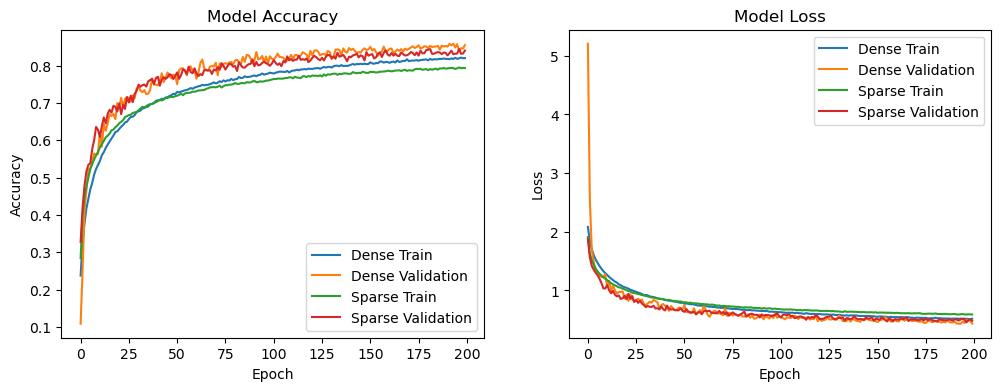

In [30]:
import matplotlib.pyplot as plt

# plotting the metrics
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(training_accuracy_dense)
plt.plot(validation_accuracy_dense)
plt.plot(training_accuracy_sparse)
plt.plot(validation_accuracy_sparse)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Dense Train', 'Dense Validation', 'Sparse Train', 'Sparse Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(training_loss_dense)
plt.plot(validation_loss_dense)
plt.plot(training_loss_sparse)
plt.plot(validation_loss_sparse)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Dense Train', 'Dense Validation', 'Sparse Train', 'Sparse Validation'], loc='upper right')

plt.show()